In [1]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS
from utils import wandb_to_xarray
import xarray as xr
import matplotlib.pyplot as plt
import fsspec
import numpy as np
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS['15day']
wandb_project = "ace"
variable_names = ["TMP2m", "TMP850", "h500", "VGRD10m"]
units = {"TMP2m": "K", "TMP850": "K", "h500": "m", "VGRD10m": "m/s", "UGRD10m": "m/s", "total_water_path": "kg/m^2"}
WEATHERBENCH_URL = 'gs://weatherbench2/results/240x121/deterministic/{model}_vs_era_2020_deterministic.nc'
WEATHERBENCH_MODELS = ['graphcast', 'era5-forecasts']

In [3]:
weatherbench_data = []
for model in WEATHERBENCH_MODELS:
    with fsspec.open(WEATHERBENCH_URL.format(model=model)) as f:
        ds = xr.open_dataset(f, engine='scipy').load()

    tmp850 = ds.sel(metric='rmse', region='global')['temperature'].sel(level=850)
    tmp2m = ds.sel(metric='rmse', region='global')['2m_temperature']
    h500 = ds.sel(metric='rmse', region='global')['geopotential'].sel(level=500) / 9.8065
    v10 = ds.sel(metric='rmse', region='global')['10m_v_component_of_wind']

    merged = xr.Dataset(
        {
            "TMP2m": tmp2m,
            "TMP850": tmp850.drop_vars('level'),
            "h500": h500.drop_vars('level'),
            "VGRD10m": v10
        }
    )

    weatherbench_data.append(merged.assign(model=model))
weatherbench_data = xr.concat(weatherbench_data, dim='model')

# fill NaNs with average of neighbors, otherwise era5-forecasts plot will be missing
# latter half, since frequency is 1 day instead of 12hr
ffill = weatherbench_data.ffill('lead_time')
bfill = weatherbench_data.bfill('lead_time')
weatherbench_data = xr.where(weatherbench_data.isnull(), (ffill + bfill) / 2, weatherbench_data)
weatherbench_data["lead_time"] = np.linspace(0, 10, len(weatherbench_data.lead_time))
weatherbench_data['lead_time'].attrs["units"] = "days since init"

/home/OliWM/miniconda3/envs/ace2-paper/lib/python3.10/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension model because variable model is not a coordinate. To create an index for model, please first call `.set_coords('model')` on this object.
  warnings.warn(


In [4]:
weatherbench_data

<xarray.Dataset> Size: 3kB
Dimensions:    (model: 2, lead_time: 41)
Coordinates:
  * model      (model) <U14 112B 'graphcast' 'era5-forecasts'
  * lead_time  (lead_time) float64 328B 0.0 0.25 0.5 0.75 ... 9.25 9.5 9.75 10.0
    region     <U6 24B 'global'
    metric     <U4 16B 'rmse'
Data variables:
    TMP2m      (model, lead_time) float64 656B nan 0.3931 0.4213 ... 2.65 2.691
    TMP850     (model, lead_time) float64 656B nan 0.1891 0.3801 ... 3.594 3.658
    h500       (model, lead_time) float64 656B nan 1.497 2.778 ... 80.32 82.19
    VGRD10m    (model, lead_time) float64 656B nan 0.2297 0.4906 ... 4.659 4.718

In [5]:
rmse_metric_names = [f"inference/mean/weighted_rmse/{name}" for name in variable_names]
metrics_ace2 = wandb_to_xarray(wandb_project, wandb_id, rmse_metric_names, samples=61)
metrics_ace2 = metrics_ace2.rename_vars({name: name.split('/')[-1] for name in rmse_metric_names})
metrics_ace2

<xarray.Dataset> Size: 2kB
Dimensions:    (lead_time: 61)
Coordinates:
  * lead_time  (lead_time) float64 488B 0.0 0.25 0.5 0.75 ... 14.5 14.75 15.0
Data variables:
    TMP2m      (lead_time) float64 488B 0.0 0.5139 0.5922 ... 3.137 3.145 3.166
    TMP850     (lead_time) float64 488B 0.0 0.5879 0.6342 ... 4.418 4.461 4.483
    h500       (lead_time) float64 488B 0.0 3.852 4.43 ... 105.7 106.5 107.0
    VGRD10m    (lead_time) float64 488B 0.0 0.6659 0.7506 ... 5.414 5.4 5.463

In [6]:
ds = xr.concat(
    [
        weatherbench_data,
        metrics_ace2.assign_coords({"model": "ACE2-ERA5"}).isel(lead_time=slice(1, 41)),
    ],
    dim="model",
    join="outer",
)
for name in ds:
    if name in units:
        ds[name].attrs["units"] = units[name]
    ds[name].attrs["long_name"] = 'RMSE'

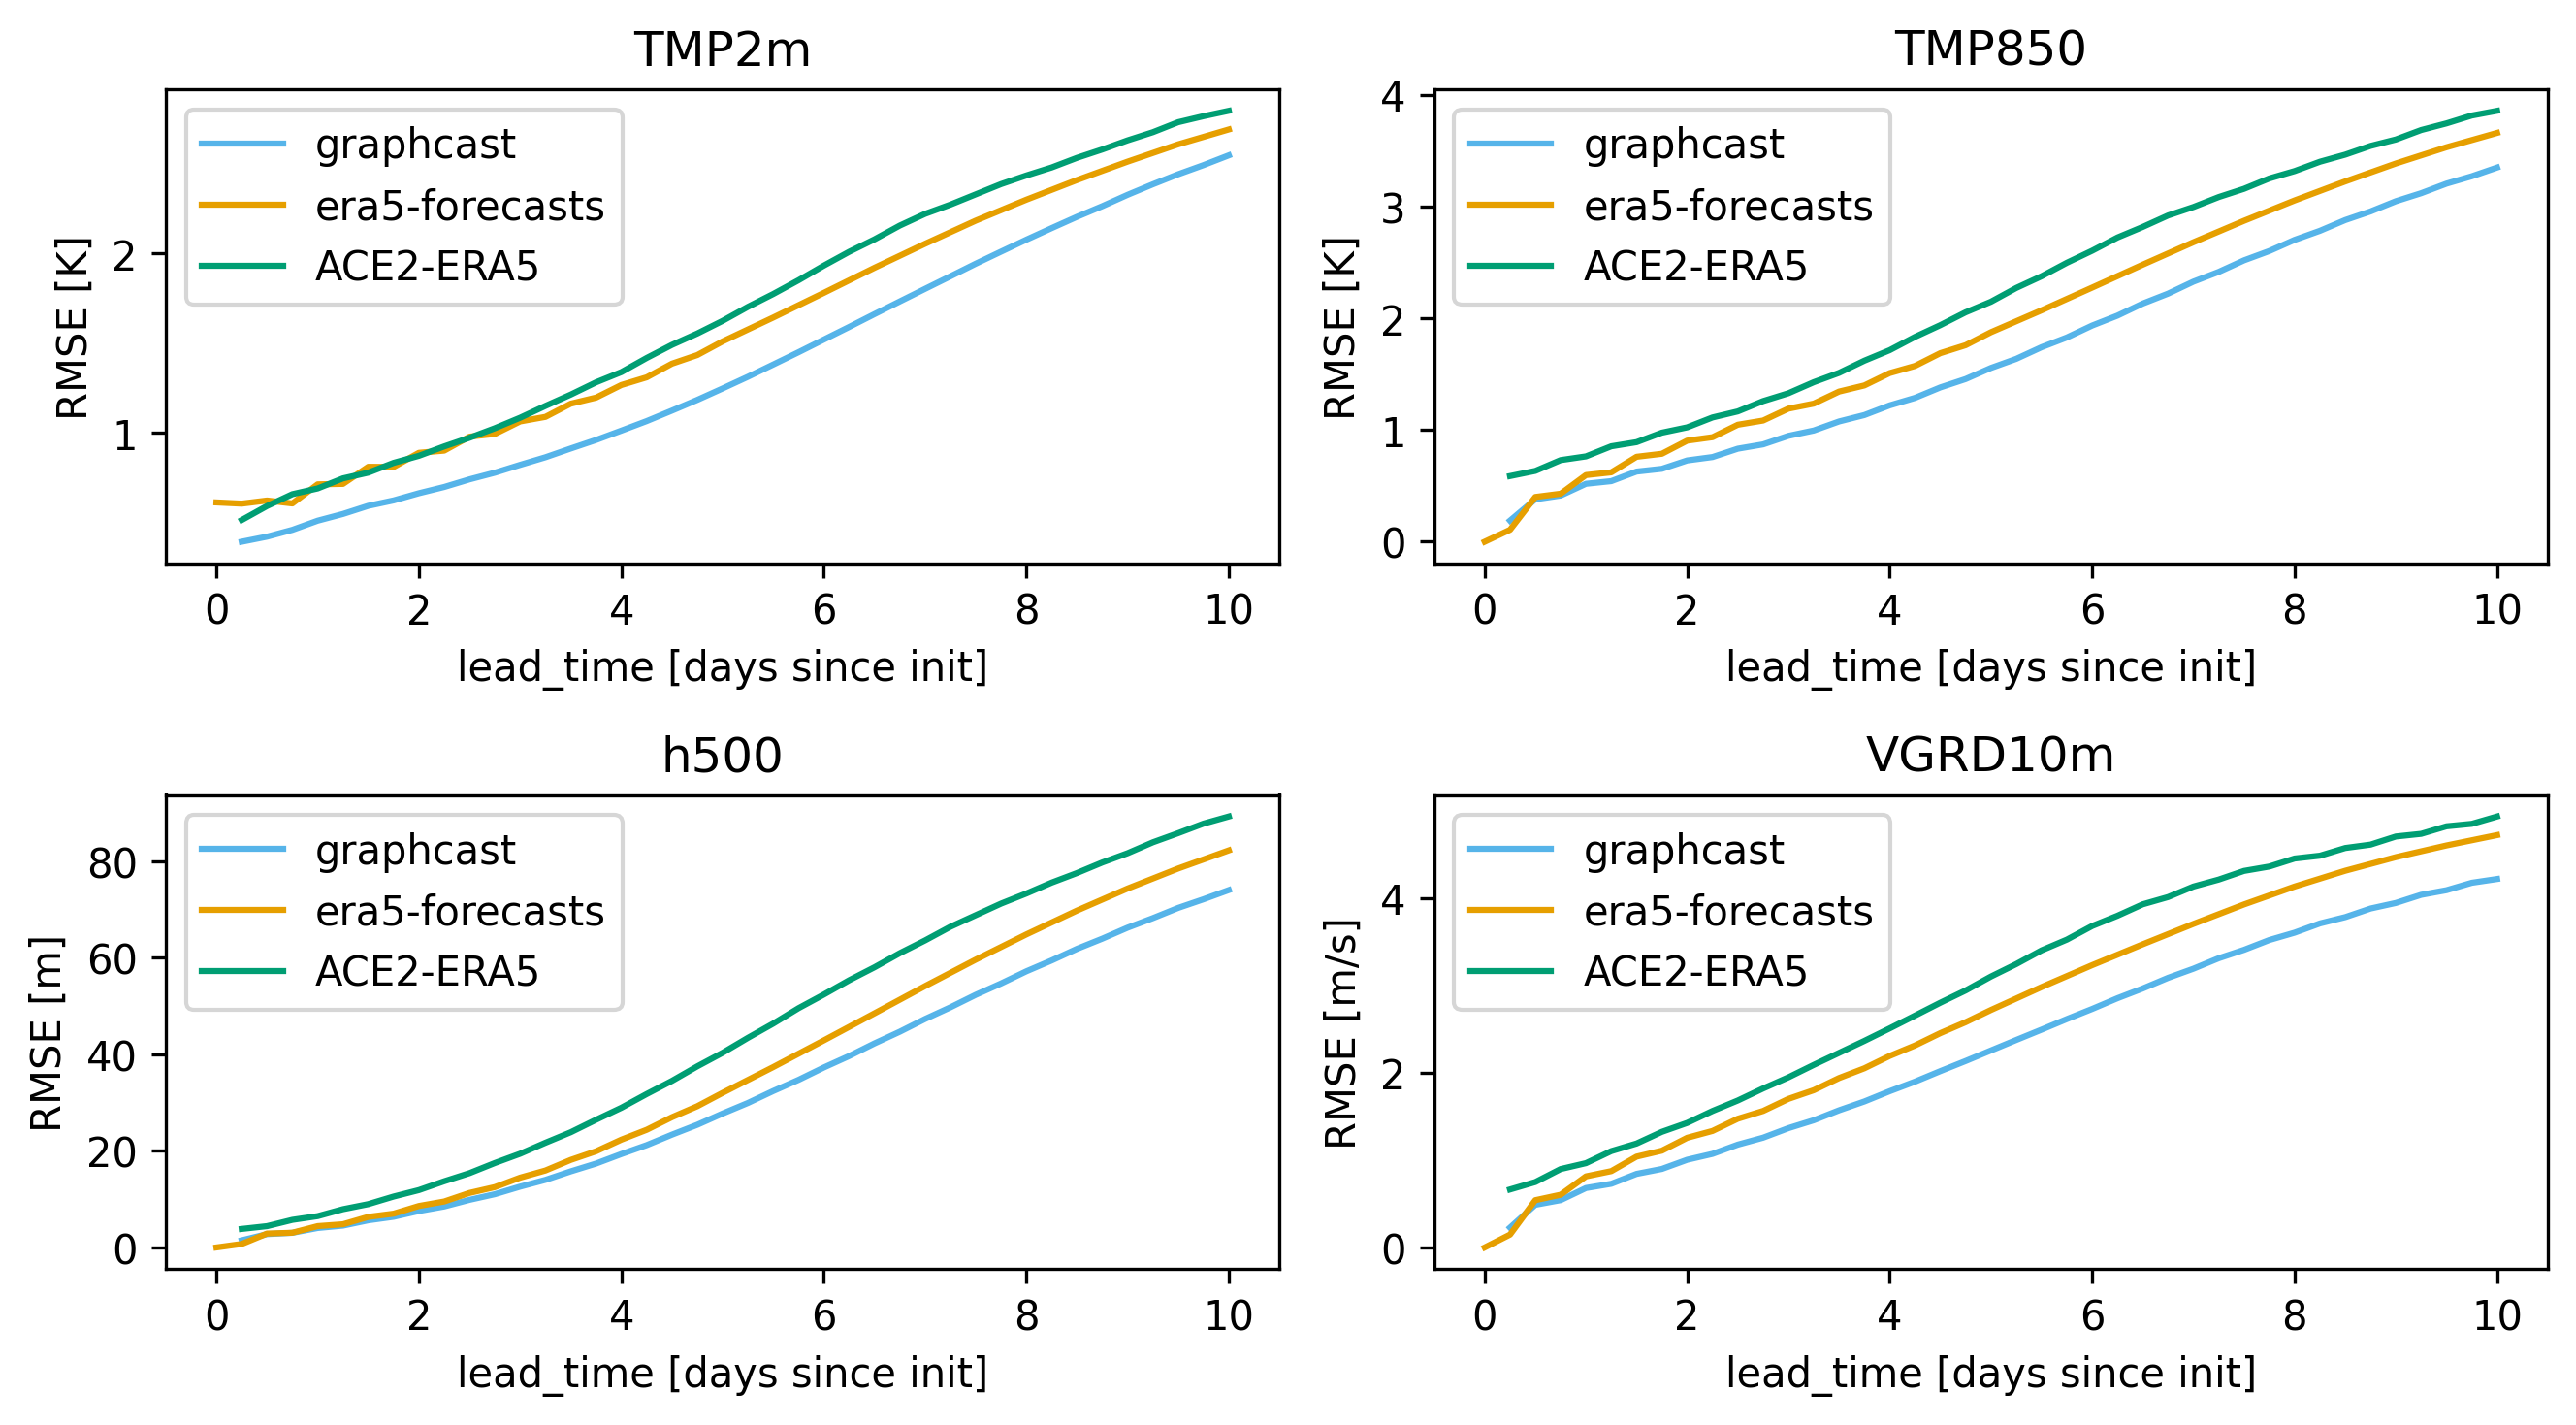

In [7]:
fig, ax = plt.subplots(2, len(variable_names) // 2, figsize=(9, 5))
ax = ax.flatten()
for i, name in enumerate(variable_names):
    ds[name].plot(ax=ax[i], hue='model')
    ax[i].set_title(name)
    ax[i].get_legend().set_title(None)
fig.tight_layout()
fig.savefig('figures/era5_weather_rmse.png', dpi=300, transparent=True)